In [20]:
# Cell 1: Install required packages and import libraries
%pip install tensorflow seaborn pandas numpy matplotlib scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set_theme(style="whitegrid")


Note: you may need to restart the kernel to use updated packages.


In [23]:
# Cell 2: Load ask and bid CSV files
ask_path = "BRENTCMDUSD_5 Mins_Ask_2025.04.01_2025.05.31.csv"
bid_path = "BRENTCMDUSD_5 Mins_Bid_2025.04.01_2025.05.31.csv"

df_ask = pd.read_csv(ask_path)
df_bid = pd.read_csv(bid_path)

print(df_ask.head())
print(df_bid.head())


            Time (UTC)    Open    High     Low   Close  Volume 
0  2025.04.01 00:00:00  74.723  74.765  74.645  74.645  0.00993
1  2025.04.01 00:05:00  74.660  74.730  74.660  74.725  0.00400
2  2025.04.01 00:10:00  74.730  74.745  74.680  74.695  0.00338
3  2025.04.01 00:15:00  74.690  74.750  74.690  74.745  0.00407
4  2025.04.01 00:20:00  74.735  74.750  74.730  74.745  0.00085
            Time (UTC)    Open    High     Low   Close  Volume 
0  2025.04.01 00:00:00  74.637  74.715  74.595  74.595  0.00835
1  2025.04.01 00:05:00  74.610  74.680  74.610  74.675  0.00385
2  2025.04.01 00:10:00  74.680  74.695  74.630  74.645  0.00354
3  2025.04.01 00:15:00  74.640  74.700  74.640  74.695  0.00320
4  2025.04.01 00:20:00  74.685  74.700  74.680  74.695  0.00094


In [24]:
# Cell 3: Merge on datetime column

def find_datetime_col(df):
    for col in df.columns:
        if "time" in col.lower() or "date" in col.lower():
            return col
    raise ValueError("Datetime column not found")

dt_ask = find_datetime_col(df_ask)
dt_bid = find_datetime_col(df_bid)

df_ask[dt_ask] = pd.to_datetime(df_ask[dt_ask])
df_bid[dt_bid] = pd.to_datetime(df_bid[dt_bid])

df = pd.merge(df_ask, df_bid, left_on=dt_ask, right_on=dt_bid, suffixes=("_Ask", "_Bid"))
df = df.sort_values(dt_ask)

df.head()


,Time (UTC),Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume _Ask,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume _Bid
0,2025-04-01 00:00:00,74.723,74.765,74.645,74.645,0.00993,74.637,74.715,74.595,74.595,0.00835
1,2025-04-01 00:05:00,74.660,74.730,74.660,74.725,0.00400,74.610,74.680,74.610,74.675,0.00385
2,2025-04-01 00:10:00,74.730,74.745,74.680,74.695,0.00338,74.680,74.695,74.630,74.645,0.00354
3,2025-04-01 00:15:00,74.690,74.750,74.690,74.745,0.00407,74.640,74.700,74.640,74.695,0.00320
4,2025-04-01 00:20:00,74.735,74.750,74.730,74.745,0.00085,74.685,74.700,74.680,74.695,0.00094


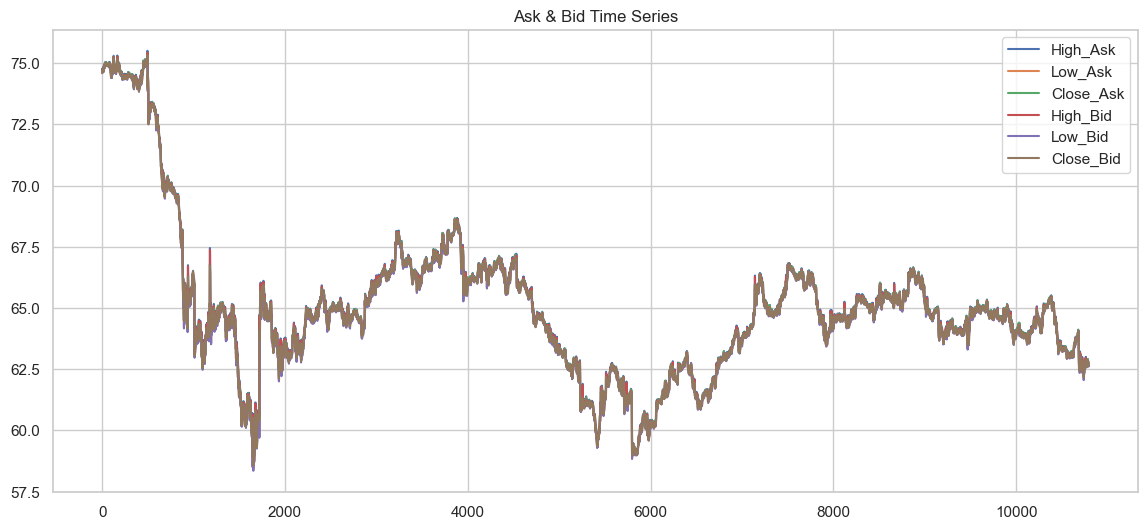

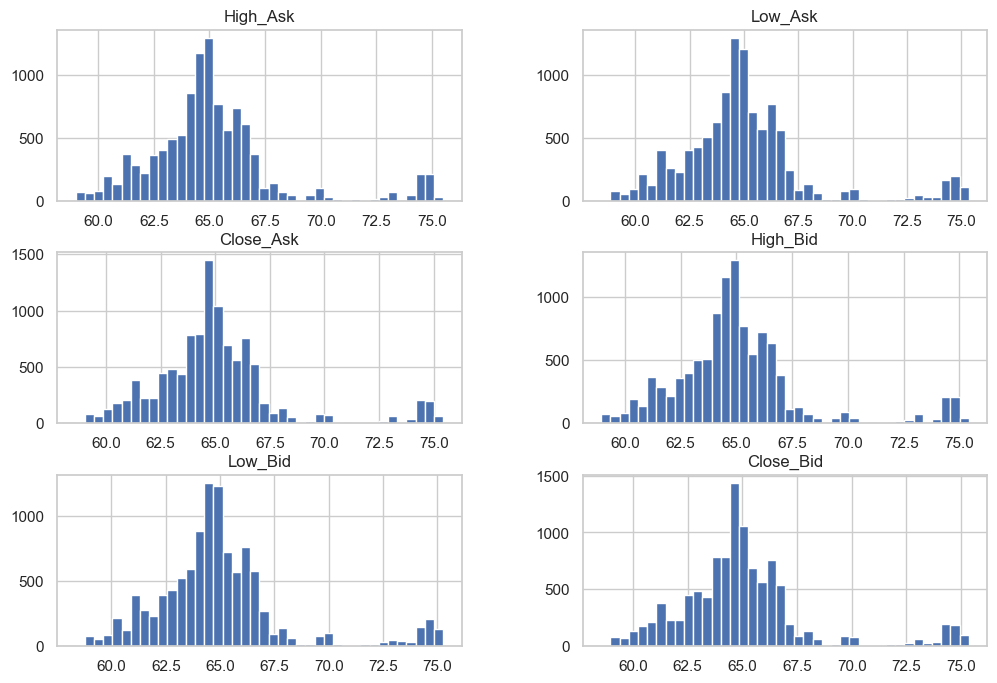

In [26]:
# Cell 4 FIXED: Use correct column names from your CSV

cols_to_plot = [
    "High_Ask", "Low_Ask", "Close_Ask",
    "High_Bid", "Low_Bid", "Close_Bid"
]

df[cols_to_plot].plot(figsize=(14,6))
plt.title("Ask & Bid Time Series")
plt.show()

df[cols_to_plot].hist(figsize=(12,8), bins=40)
plt.show()


In [27]:
# Cell 5 FIXED: Create y using your column names

df["High_Bid_next"] = df["High_Bid"].shift(-1)
df["Low_Ask_next"]  = df["Low_Ask"].shift(-1)

df = df.dropna()
y_raw = df[["High_Bid_next", "Low_Ask_next"]].values

print(y_raw.shape)


(10793, 2)


In [28]:
# Cell 6: Scale features and targets
numeric_cols = df.select_dtypes(include=[np.number]).columns
X_raw = df[numeric_cols].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)


In [29]:
# Cell 7: Convert to windowed sequences (24 timesteps)
window_size = 24

def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)
X_seq.shape, y_seq.shape


((10769, 24, 12), (10769, 2))

In [30]:
# Cell 8: Split into train/test (85/15)
total = len(X_seq)
train_count = int(total * 0.85)

X_train = X_seq[:train_count]
X_test = X_seq[train_count:]

y_train = y_seq[:train_count]
y_test = y_seq[train_count:]

X_train.shape, X_test.shape


((9153, 24, 12), (1616, 24, 12))

In [31]:
# Cell 9: Build CNN model (model_alt)
n_features = X_train.shape[2]
input_shape = (window_size, n_features)

model_alt = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(2)  # predicting 2 values
])

model_alt.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_alt.summary()


C:\Users\ssh136\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 22, 32)         │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,922 (38.76 KB)

 Trainable params: 9,730 (38.01 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
whos


In [32]:
# Cell 10: Training with EarlyStopping + checkpoint

checkpoint_path = "/mnt/data/best_cnn.weights.h5"

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    mode="min",
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1
)

history = model_alt.fit(
    X_train,
    y_train,
    epochs=13,
    batch_size=50,
    validation_split=0.15,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/13
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5128 - mae: 0.4544 
Epoch 1: val_loss improved from None to 0.01782, saving model to /mnt/data/best_cnn.weights.h5
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2761 - mae: 0.3440 - val_loss: 0.0178 - val_mae: 0.1072
Epoch 2/13
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1286 - mae: 0.2450   
Epoch 2: val_loss improved from 0.01782 to 0.01339, saving model to /mnt/data/best_cnn.weights.h5
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1250 - mae: 0.2404 - val_loss: 0.0134 - val_mae: 0.0897
Epoch 3/13
146/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1135 - mae: 0.2245    
Epoch 3: val_loss improved from 0.01339 to 0.01192, saving model to /mnt/data/best_cnn.weights.h5
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1095 - mae: 0.2210 - val_loss: 0.0119 - val_mae: 0.0864
Epoch 4/13
143/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1005 - mae: 0.2153    
Epoch 4: val_loss improved from 0.01192 to 0.00902, 

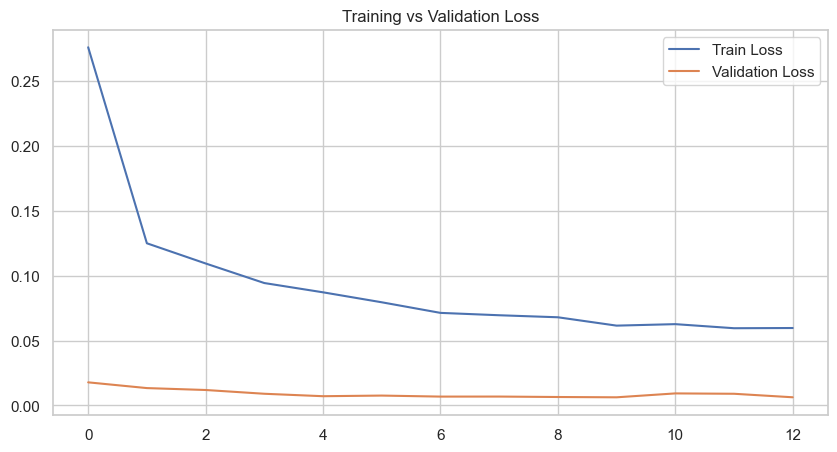

In [33]:
# Cell 11: Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [34]:
# Cell 12: Load best weights + evaluate
model_alt.load_weights(checkpoint_path)

y_pred_scaled = model_alt.predict(X_test)

y_test_orig = scaler_y.inverse_transform(y_test)
y_pred_orig = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)

print("MSE:", mse)
print("MAE:", mae)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
MSE: 0.07812306190668342
MAE: 0.21311637562100266
